In [ ]:
from __future__ import print_function
import os, math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm_class
import torchvision
from PIL import Image
from copy import deepcopy
from model import UNet
import tqdm.notebook
from sde import marginal_prob_std, marginal_prob_std_fn, diffusion_coeff, diffusion_coeff_fn
device="cuda"

# Samplers

In [ ]:
#
## The number of sampling steps.
num_steps =  500#param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.   
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 64, 64, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [ ]:
#

signal_to_noise_ratio = 0.16 #

## The number of sampling steps.
num_steps =  500#
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 64, 64, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

In [ ]:
#title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 3, 64, 64, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

In [ ]:
# We will resize to 64 x 64 for this assignment
image_size = 64

# Run on GPU
device = 'cuda'

class Diffusion:
    ''' 
    Implements the Diffusion process,
    including both training and sampling.
    '''
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device = 'cuda'):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = torch.linspace(beta_start,beta_end,num_timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    def get_noisy_image(self, x_0, t):
        '''
        This function is only used for training.
        '''     
        
        eps = torch.randn_like(x_0).to(self.device)
        alpha_t = self.alpha[t]
        alpha_bar_t = self.alpha_bar[t]
        x_t = torch.sqrt(alpha_bar_t)[:,None,None,None] * x_0 + torch.sqrt(1 - alpha_bar_t)[:,None,None,None] * eps
        return (x_t, eps)
    def sample(self, model, n, y=None):
        '''
        This function is used  to generate images.
        '''
        model.eval()
        
        with torch.no_grad():

            T = self.num_timesteps
            H = self.img_size
            W = self.img_size
            x_T = torch.randn(n, 3, H, W, device=self.device)
            for k in range(T):
                t = T-k-1
                if t == (T-1):
                  x_t = x_T
                
                epsilon = model(x_t, (torch.ones(n)*t).long().to(self.device), y)
                
                mu = (1/torch.sqrt(self.alpha[t]))*(x_t - self.beta[t]*epsilon/torch.sqrt(1-self.alpha_bar[t]))
                if t>0:
                  x_t = torch.randn_like(mu, device=self.device)*torch.sqrt(self.beta[t]) + mu
            x=x_t
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x
    
def show_images(images, **kwargs):
    plt.figure(figsize=(10, 10), dpi=80)
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    plt.imshow(im)
    plt.show()
    

def set_random_seed(seed=999):
    # Set random seed for reproducibility
    print("Random Seed: ", seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [ ]:

from torchvision.utils import make_grid
score_model = torch.nn.DataParallel(UNet(marginal_prob_std = marginal_prob_std_fn))
score_model = score_model.to(device)
## Load the pre-trained checkpoint from disk.
device = 'cuda' #param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #param {'type':'integer'}
sampler = Euler_Maruyama_sampler #param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
temp = samples
samples = samples.clamp(0.0, 1.0)
%matplotlib inline

import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
temp=temp.clamp(0.0,1.0)
plt.figure(figsize=(6,6))
for i in range(sample_batch_size):
  sample_grid = make_grid(samples[i], nrow=int(np.sqrt(sample_batch_size)))
 
  img = torchvision.transforms.ToPILImage()(sample_grid)
  img.show()
  torchvision.utils.save_image(sample_grid, './save_img/img%s.jpg' % i)


In [ ]:

opendir = "./img_align_celeba/"
for i in os.listdir(opendir):
  image = Image.open(opendir+i)
  convert_tensor = transforms.ToTensor()
  image=convert_tensor(image)
  transform = torchvision.transforms.Resize(64)
  image = transform(image)
  
  torchvision.utils.save_image(image, "save_img_1/"+i)

In [ ]:
model = UNet().to(device)
ema_model = deepcopy(model)

ema_model_state_dict, model_state_dict = torch.load('ddpm.pt')
ema_model.load_state_dict(ema_model_state_dict)
model.load_state_dict(model_state_dict)
diffusion = Diffusion(img_size=image_size, device=device)
set_random_seed()
y_gender = torch.cat((torch.zeros(32, dtype=torch.long), torch.ones(32, dtype=torch.long)))
sampled_images = diffusion.sample(ema_model, n=64,y=y_gender.cuda()) 

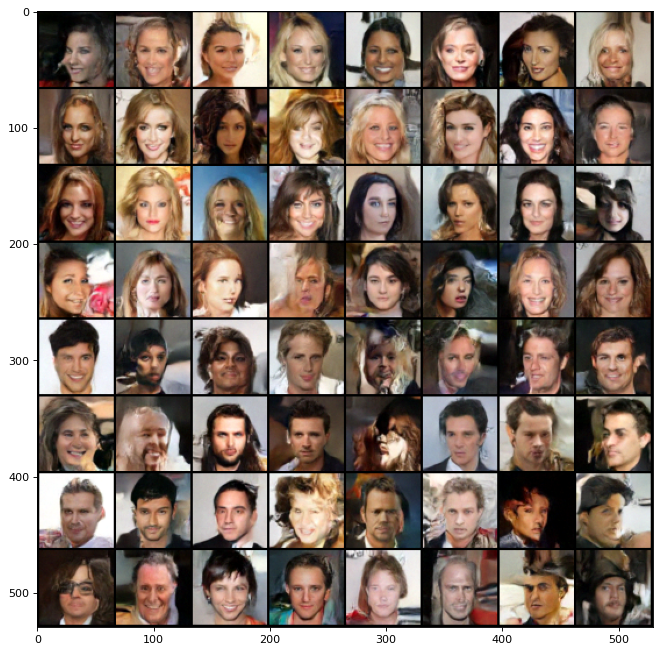

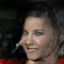

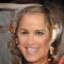

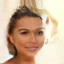

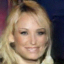

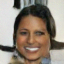

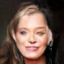

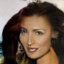

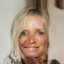

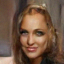

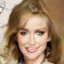

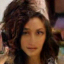

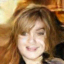

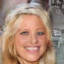

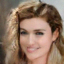

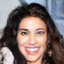

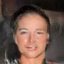

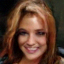

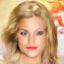

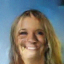

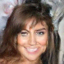

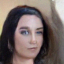

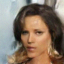

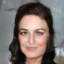

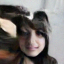

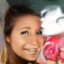

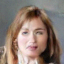

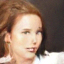

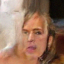

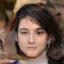

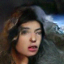

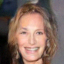

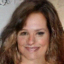

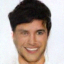

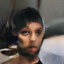

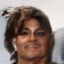

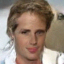

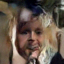

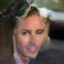

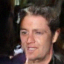

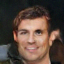

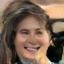

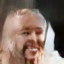

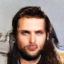

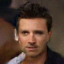

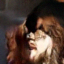

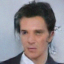

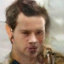

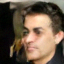

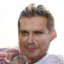

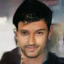

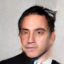

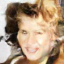

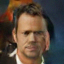

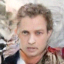

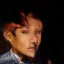

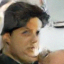

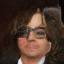

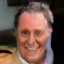

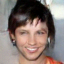

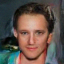

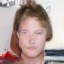

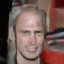

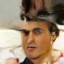

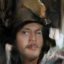

<Figure size 600x600 with 0 Axes>

In [ ]:
show_images(sampled_images)


plt.figure(figsize=(6,6))
for i in range(64):
  sample_grid = make_grid(sampled_images[i], nrow=int(np.sqrt(64)))
 
  img = torchvision.transforms.ToPILImage()(sample_grid)
  img.show()
  
  img.save('./save_img/img%s.jpg' % i)


# FID 



In [ ]:
!pip install pytorch-fid

In [ ]:
!python -m pytorch_fid save_img save_img_1


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 180MB/s]
100% 2/2 [00:01<00:00,  1.82it/s]
100% 3269/3269 [11:03<00:00,  4.93it/s]
FID:  100.70351844329082
